In [8]:
from argparse import Namespace
import sys, pathlib, pdb, os
from os.path import join

sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../CausalMBRL')
sys.path.append('../../CausalMBRL/envs')

from tqdm import tqdm
import utils
import ruamel.yaml as yaml

from conv_decoder_bcd_utils import *
import envs, wandb
import jax
from jax import numpy as jnp
import numpy as onp
import jax.random as rnd
from jax import config, jit, lax, value_and_grad, vmap
from jax.tree_util import tree_map, tree_multimap
import haiku as hk
from modules.GumbelSinkhorn import GumbelSinkhorn

from loss_fns import *
from tensorflow_probability.substrates.jax.distributions import (Horseshoe,
                                                                 Normal)
from conv_decoder_bcd_eval import *

opt = Namespace(**{
    'data_seed': 0,
    'pts_per_interv': 20,
    'n_interv_sets': 20,
    'obs_data': 100,
    'num_nodes': 5,
    'exp_edges': 1.0,
    'noise_sigma': 1.0,
    'do_ev_noise': True,
    'dataset': 'chemdata',
    'sem_type': 'linear-gauss',
    'generate': True
})

# ? Set seeds
onp.random.seed(0)
rng_key = rnd.PRNGKey(opt.data_seed)
key = hk.PRNGSequence(42)

opt.num_samples = int(opt.pts_per_interv * opt.n_interv_sets) + opt.obs_data
n = opt.num_samples
d = opt.num_nodes
degree = opt.exp_edges
l_dim = d * (d - 1) // 2
ground_truth_sigmas = opt.noise_sigma * jnp.ones(opt.num_nodes)

if opt.do_ev_noise: noise_dim = 1
else:   noise_dim = d

low = -8.
high = 8.
hard = True
num_bethe_iters = 20
proj_dims = (1, 50, 50)
log_stds_max=10.

In [9]:
z, interv_nodes, interv_values, images, gt_W, gt_P, gt_L = generate_data(opt, low, high)

WARN: Box bound precision lowered by casting to float32
100%|██████████| 500/500 [00:03<00:00, 146.94it/s]


[[ 0.         -0.          0.         -0.          0.        ]
 [-0.         -0.         -0.          0.          0.        ]
 [-0.         -0.5281847  -0.         -0.          0.        ]
 [-0.89683342 -0.         -0.          0.         -0.        ]
 [ 0.         -1.41814358  0.         -0.         -0.        ]]



In [10]:
images.shape

(500, 50, 50, 3)

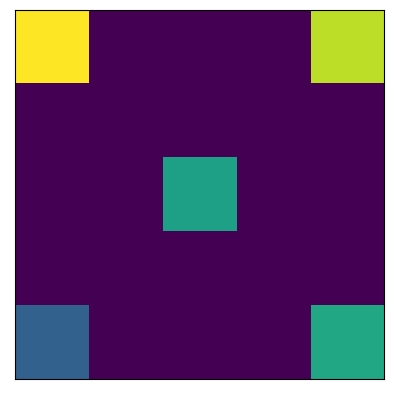

In [19]:
import matplotlib.pyplot as plt

plt.imshow(images[101, :, :, 0]/255)
plt.xticks([])
plt.yticks([])
plt.show()

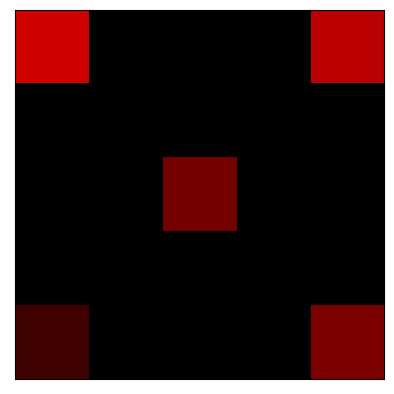

In [20]:
plt.imshow(images[101, :, :]/255)
plt.xticks([])
plt.yticks([])
plt.show()